In [1]:
import numpy as np
import torch
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.notebook import tqdm
from typing import Optional

/home/sasha/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [2]:
class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(256 * 1 * 1, 256) 
        self.fc2 = nn.Linear(256, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 1 * 1) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

In [3]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)
class BayesModule(nn.Module): 
    def __init__(self, module, t: int = 1e-4): 
        super().__init__() 
        self.base_module = [module]
        self.list_param_mus = nn.ParameterList()
        self.list_param_std = nn.ParameterList()
        self.list_scale_mus = nn.ParameterList()
        self.list_scale_alphas_log = nn.ParameterList() 
        self.dropout_mask = nn.ParameterList() 
        self.t = t
        self.index_to_name = []
        i = 0
        for (name, p) in list(self.base_module[0].named_parameters()):
            p.requires_grad = False
            self.index_to_name.append(name)
            self.list_param_mus.append(nn.Parameter(p, requires_grad = True))
            self.list_param_std.append(nn.Parameter(torch.Tensor(p.shape).uniform_(0, 0.01), requires_grad = True)) #(0, 0.01)
            self.list_scale_mus.append(nn.Parameter(torch.ones_like(p), requires_grad = True))
            self.list_scale_alphas_log.append(nn.Parameter(torch.Tensor(p.shape).uniform_(-4, -2), requires_grad = True)) #(-4, -2)
            self.dropout_mask.append(nn.Parameter(torch.ones_like(p), requires_grad = False))
            i += 1
    @property
    def device(self):
        return self.list_param_mus[0].device
    def prune(self, t: Optional[int] = None):
        if(t is not None):
            self.t = t
        for i in range(len(self.dropout_mask)):
            self.dropout_mask[i].data = 1.0 * (self.list_scale_alphas_log[i] <= self.t)
    def prune_stats(self):
        prune_cnt = 0
        for i in range(len(self.dropout_mask)):
            prune_cnt += (1 - self.dropout_mask[i]).sum()
        return prune_cnt
    def total_params(self):
        prune_cnt = 0
        for i in range(len(self.dropout_mask)):
            prune_cnt += self.dropout_mask[i].shape.numel()
        return prune_cnt
    def get_kl_divergence(self):
        k1 = torch.tensor(0.63576)
        k2 = torch.tensor(1.87320)
        k3 = torch.tensor(1.48695)
        KL_z = 0
        for i in range(len(self.list_param_mus)):
            KL_z_element = k1 * F.sigmoid(k2 + k3 * self.list_scale_alphas_log[i]) - 0.5 * F.softplus(-self.list_scale_alphas_log[i]) - k1
            KL_z = KL_z + KL_z_element.sum()
        KL_w = 0
        for i in range(len(self.list_param_mus)):
            KL_w_element = 0.5 * (torch.log(1/self.list_param_std[i]**2) + self.list_param_std[i]**2 + self.list_param_mus[i] ** 2 - 1)
            KL_w = KL_w  + KL_w_element.sum()
        
        return -KL_z + KL_w                              
    def calculate_params(self): 
        for i in range(len(self.list_scale_mus)):
                pt = self.list_scale_mus[i] * self.dropout_mask[i] * self.list_param_mus[i]
                #pt = torch.nn.Parameter(pt.to_sparse())
                del_attr(self.base_module[0], self.index_to_name[i].split("."))
                set_attr(self.base_module[0], self.index_to_name[i].split("."), pt)
    def forward(self, x, sample = True): 
        self.base_module[0].to(self.device)
        if sample == True:
            for i in range(len(range(len(self.list_scale_mus)))):
                # sample gaussian for each weight and scale
                param_epsilons = Variable(torch.randn_like(self.list_param_mus[i]))
                scale_epsilons = Variable(torch.randn_like(self.list_param_mus[i]))
                # calculate sample using reparametrization
                scale_sample = self.list_scale_mus[i] + scale_epsilons * (self.list_scale_mus[i]) * torch.sqrt(torch.exp(self.list_scale_alphas_log[i].data))
                param_sample = scale_sample * (self.list_param_mus[i] + param_epsilons * self.list_param_std[i])
                del_attr(self.base_module[0], self.index_to_name[i].split("."))
                set_attr(self.base_module[0], self.index_to_name[i].split("."), param_sample)
            x = self.base_module[0](x)
        else:   
            self.calculate_params()
            x = self.base_module[0](x)
        return x, self.get_kl_divergence()

In [4]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [48]:
module = Classifier()

In [49]:
bayes_model = BayesModule(module)

In [52]:
cnt = 0
for i, p in enumerate(bayes_model.parameters()):
    cnt += 1
print(cnt)

40


In [50]:
a = torch.tensor([[0, 2.], [3, 0]])
b =  torch.tensor([1., 1.])
a_s = a.to_sparse()
print(a_s @ b)

tensor([2., 3.])


In [10]:
optimizer = optim.Adam(bayes_model.parameters(), lr=0.1)

In [11]:
image, label = test_dataset[10]
y, _ = bayes_model(torch.ones_like(image), sample = True)
out = _.sum()
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

In [12]:
print(bayes_model(torch.zeros_like(image), sample = True))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

(tensor([[ 2.4534,  1.1753, -3.7792,  1.0919,  1.6042, -0.7641,  0.9655, -1.7372,
          1.3738,  1.1126]], grad_fn=<AddmmBackward0>), tensor(1608409.3750, grad_fn=<AddBackward0>))
tensor([[ 2.4534,  1.1753, -3.7792,  1.0919,  1.6042, -0.7641,  0.9655, -1.7372,
          1.3738,  1.1126]], grad_fn=<AddmmBackward0>)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [13]:
class Beta_Shelduer_Plato():
    def __init__(self, beta: float = 1e-2, alpha: float = 1e-1, patience: int = 10, is_min: bool = True, threshold: float = 0.01, eps: float=1e-08, max_beta: float= 1., min_beta:float=1e-9, ref = None):
        self.ref = self
        self.beta = beta
        if(ref is not None):
            self.ref = ref
            self.beta = ref.beta
        self.cnt_upward = 0
        self.prev_opt = None
        self.patience = patience
        self.alpha = alpha
        self.is_min = is_min
        self.max_beta = max_beta
        self.min_beta = min_beta
        self.threshold = threshold
        self.eps = eps
    def step(self, loss):
        if (self.prev_opt is not None) and (loss > self.prev_opt - abs(self.prev_opt) * self.threshold):
            self.cnt_upward += 1
        else:
            self.cnt_upward = 0
        if (self.cnt_upward < self.patience) ^ (self.is_min):
            new_beta = self.alpha * self.ref.beta
            if abs(new_beta - self.ref.beta) > self.eps:
                new_beta = min(new_beta, self.max_beta)
                new_beta = max(new_beta, self.min_beta)
                self.ref.beta =  new_beta
        if self.prev_opt is None:
            self.prev_opt = loss
        elif self.is_min == True:
            self.prev_opt = min(self.prev_opt, loss)
        else:
            self.prev_opt = max(self.prev_opt, loss)
    def __float__(self):
        return self.ref.beta

In [9]:
beta = Beta_Shelduer_Plato()
dir(beta)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__float__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alpha',
 'beta',
 'cnt_upward',
 'eps',
 'is_min',
 'max_beta',
 'min_beta',
 'patience',
 'prev_opt',
 'ref',
 'step',
 'threshold']

In [14]:
torch.autograd.set_detect_anomaly(True)
BATCH_SIZE=1000
EPOCHS=1000
LR = 5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5
BETA_FAC = 5e-1
PRUNE = -2.1#-1.99, -2.1
PLATO_TOL = 10
# Instantiate the model 
model = model = BayesModule(Classifier())
model.to(device) 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=LR)
no_samples = SAMPLES
beta = Beta_Shelduer_Plato(BETA, BETA_FAC, PLATO_TOL)
#beta_KL = Beta_Shelduer_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)
beta_KL = Beta_Shelduer_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,  
                                                           [train_size,  
                                                            val_size]) 
  
# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(train_dataset,  
                                           batch_size=BATCH_SIZE,  
                                           shuffle=True, 
                                           pin_memory=True) 
val_loader = torch.utils.data.DataLoader(val_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
losses = [] 
accuracies = [] 
val_losses = [] 
val_accuracies = [] 
# Train the model 


            
for epoch in tqdm(range(EPOCHS)): 
    for i, (images, labels) in enumerate(train_loader): 
        # Forward pass 
        images=images.to(device) 
        labels=labels.to(device) 
        fit_loss_total = 0 
        for j in range(no_samples):
            outputs, KL_loss_total = model(images)
            # calculate fit loss based on mean and standard deviation of output
            #fit_loss_total = fit_loss_total + criterion(outputs, labels)  
            fit_loss_total = fit_loss_total + criterion(outputs, labels)  
        total_loss = (fit_loss_total)/(no_samples) + float(beta) *KL_loss_total
        
        # Backward pass and optimization 
        optimizer.zero_grad() 
        total_loss.backward() 
        optimizer.step()
        beta.step(fit_loss_total) 
        beta_KL.step(KL_loss_total)  
  
        _, predicted = torch.max(outputs.data, 1) 
    acc = (predicted == labels).sum().item() / labels.size(0) 
    accuracies.append(acc) 
    losses.append(total_loss.item())   
          
    # Evaluate the model on the validation set 
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        model.prune(t = PRUNE) 
        for images, labels in val_loader: 
            labels=labels.to(device) 
            images=images.to(device) 
            fit_loss_total = 0 
            for j in range(no_samples):
                outputs, KL_loss_total = model(images, sample = False)

                # calculate fit loss based on mean and standard deviation of output
                fit_loss_total = fit_loss_total + criterion(outputs, labels)  
            total_loss = (fit_loss_total)/(no_samples) + float(beta)* KL_loss_total
            val_loss += total_loss.item() 
              
            _, predicted = torch.max(outputs.data, 1) 
        total = labels.size(0) 
        
        correct = (predicted == labels).sum().item() 
        val_acc += correct / total 
        val_accuracies.append(acc) 
        val_losses.append(total_loss.item())   
        
        cnt_prune_parameters = model.prune_stats()
        cnt_params = model.total_params()
    if(i % 10 == 0):
        torch.save(model.state_dict(), 'model.pt')
        
    print(f'Epoch [{epoch+1}/{EPOCHS}],Loss:{total_loss.item()}, KL Loss: {KL_loss_total}. FitLoss: {fit_loss_total / no_samples}, Validation Loss:{val_loss},Accuracy:{acc},Validation Accuracy:{val_acc}, Prune parameters: {cnt_prune_parameters}/{cnt_params}, Beta: {float(beta)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000],Loss:29517.5390625, KL Loss: 2951524.0. FitLoss: 2.298102617263794, Validation Loss:59035.078125,Accuracy:0.0875,Validation Accuracy:0.10166666666666667, Prune parameters: 23637.0/456202, Beta: 0.01
Epoch [2/1000],Loss:1753.9571533203125, KL Loss: 2802659.0. FitLoss: 2.295348882675171, Validation Loss:3507.914794921875,Accuracy:0.2025,Validation Accuracy:0.18, Prune parameters: 24392.0/456202, Beta: 0.000625
Epoch [3/1000],Loss:15.636658668518066, KL Loss: 2734660.75. FitLoss: 2.283823013305664, Validation Loss:31.2721004486084,Accuracy:0.1425,Validation Accuracy:0.13166666666666665, Prune parameters: 24875.0/456202, Beta: 4.8828125e-06
Epoch [4/1000],Loss:2.327971935272217, KL Loss: 2703129.75. FitLoss: 2.224855661392212, Validation Loss:4.649439573287964,Accuracy:0.2125,Validation Accuracy:0.21833333333333332, Prune parameters: 25133.0/456202, Beta: 3.814697265625e-08
Epoch [5/1000],Loss:1.9941354990005493, KL Loss: 2687539.25. FitLoss: 1.942874789237976, Validation Lo

KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [131]:
model.prune(t = -5)
print(model.prune_stats())

tensor(421642., device='cuda:0')


In [20]:
val_loss = 0.0
val_acc = 0.0
PRUNE = -2.2
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
model.prune(t = PRUNE)
cnt_prune_parameters = model.prune_stats()
with torch.no_grad(): 
        for images, labels in test_loader: 
            labels=labels.to(device) 
            images=images.to(device) 
            fit_loss_total = 0 
            for j in range(no_samples):
                outputs, KL_loss_total = model(images, sample = False)

                # calculate fit loss based on mean and standard deviation of output
                fit_loss_total = fit_loss_total + criterion(outputs, labels)  
            total_loss = (fit_loss_total)/(no_samples) + float(beta)* KL_loss_total
            val_loss += total_loss.item() 
              
            _, predicted = torch.max(outputs.data, 1) 
        total = labels.size(0) 
        
        correct = (predicted == labels).sum().item() 
        val_acc += correct / total 
print(f'Loss:{val_loss}, KL Loss: {KL_loss_total}, FitLoss: {fit_loss_total / no_samples}, Accuracy {val_acc}, Prune parameters: {cnt_prune_parameters}/{cnt_params}, Beta: {float(beta)}')

Loss:4759.93342590332, KL Loss: 2029048.0, FitLoss: 0.05577563866972923, Accuracy 0.991, Prune parameters: 85835.0/456202, Beta: 3.90625e-05


Label: 3


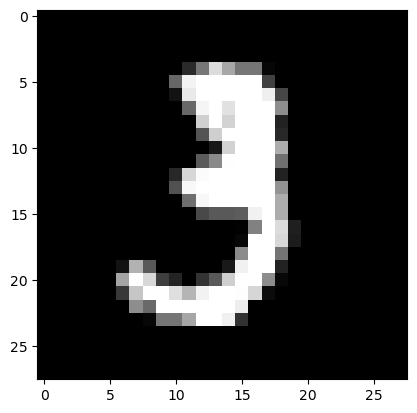

In [21]:
image, label = test_dataset[10]
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
print('Label:', label)

In [23]:
torch.max(model(image.cuda(), sample = False)[0].data, 1)

torch.return_types.max(
values=tensor([14.5866], device='cuda:0'),
indices=tensor([3], device='cuda:0'))